NOTES FROM MILLY:
* DO THE FUCKING T TEST

# Northing Wind Trading Co.

## Hypothesis:

1. Do discounts affect the quantity ordered.
1. Processing time equals the mean.
1. 
1. 

## SQL Queries Using SqLite3
### Northwind ERD
<img src='northwind_ERD.png'>

### Importing sqlite database

In [1]:
import sqlite3
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

### List of Tables

In [2]:
c.execute('''
SELECT name
FROM sqlite_master
WHERE type='table';
''').fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

## SQL for EDA
List of the columns in OrderDetail

In [3]:
c.execute('''
PRAGMA table_info(OrderDetail)
''').fetchall()

[(0, 'Id', 'VARCHAR(8000)', 0, None, 1),
 (1, 'OrderId', 'INTEGER', 1, None, 0),
 (2, 'ProductId', 'INTEGER', 1, None, 0),
 (3, 'UnitPrice', 'DECIMAL', 1, None, 0),
 (4, 'Quantity', 'INTEGER', 1, None, 0),
 (5, 'Discount', 'DOUBLE', 1, None, 0)]

SQL has some native functions that can be used for EDA, which we will explor here. The following function that we will be using will be:

* Min
* Max
* Average

In [4]:
c.execute('''
SELECT Discount, COUNT(Discount)
FROM OrderDetail
GROUP BY Discount
ORDER BY Discount;
''').fetchall()

[(0.0, 1317),
 (0.01, 1),
 (0.02, 2),
 (0.03, 3),
 (0.04, 1),
 (0.05, 185),
 (0.06, 1),
 (0.1, 173),
 (0.15, 157),
 (0.2, 161),
 (0.25, 154)]

In [5]:
c.execute('''
SELECT AVG(Discount), MIN(Discount), MAX(Discount)
FROM OrderDetail;
''').fetchall()

[(0.05616705336426916, 0.0, 0.25)]

Avg: .06

Min: 0.0

Max: 0.25

The average discount per order is 6%, but looking at the orders. As there is no native median function is SQL we will do the remaining EDA using Pandas and Numpy.

## Importing Pandas & Numpy for EDA

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
orders = pd.read_sql_query('''
SELECT *
FROM OrderDetail;
''', conn)

In [8]:
orders.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [9]:
orders.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [10]:
orders.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


### Visual EDA Using Matplotlib & Seaborn

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [12]:
discount_false = orders[orders['Discount'] == 0.0]
discount_true = orders[orders['Discount'] > 0.0]

In [13]:
discount_false.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [14]:
discount_true.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05
11,10252/20,10252,20,64.8,40,0.05


### Histograms

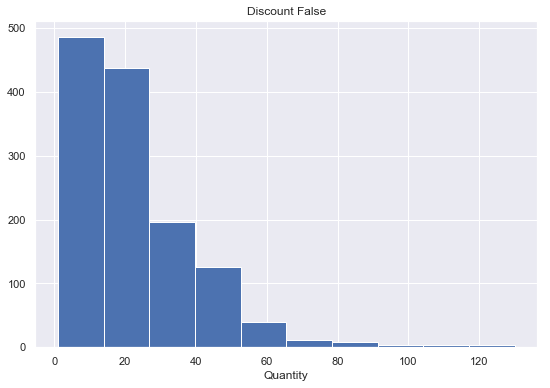

In [15]:
_ = plt.figure(figsize=(9,6))
_ = plt.hist(discount_false['Quantity'])
_ = plt.title('Discount False')
_ = plt.xlabel('Quantity')
plt.show()

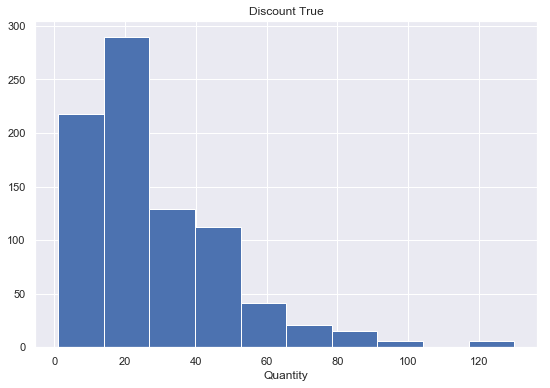

In [16]:
_ = plt.figure(figsize=(9,6))
_ = plt.hist(discount_true['Quantity'])
_ = plt.title('Discount True')
_ = plt.xlabel('Quantity')
plt.show()

### Bee Swarm Plot

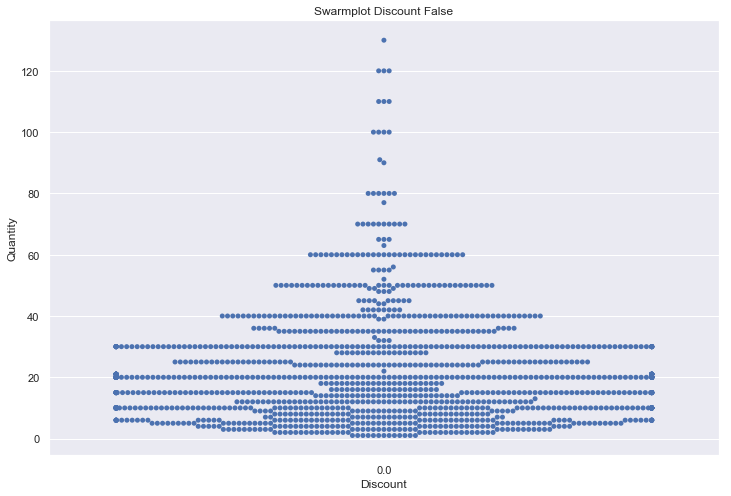

In [17]:
sns.set()
plt.figure(figsize=(12, 8))
sns.swarmplot(x=discount_false['Discount'], y=discount_false['Quantity'])
plt.title('Swarmplot Discount False')
plt.show()

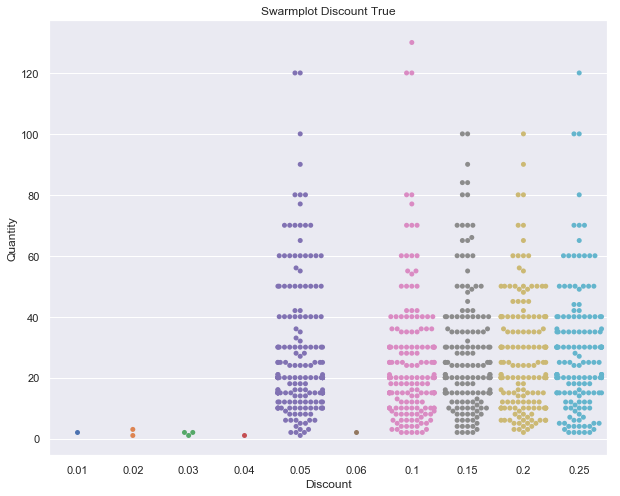

In [18]:
plt.figure(figsize=(10, 8))
sns.swarmplot(x=discount_true['Discount'], y=discount_true['Quantity'])
plt.title('Swarmplot Discount True')
plt.show()

### CDFS

In [19]:
def ecdf(data):
    '''
    Computes the ECDF for a given dataset.
    
    data: a list or array.
    
    returns: x, y
    '''
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    
    return x, y

In [20]:
quantity_x, quantity_y = ecdf(discount_false['Quantity'])

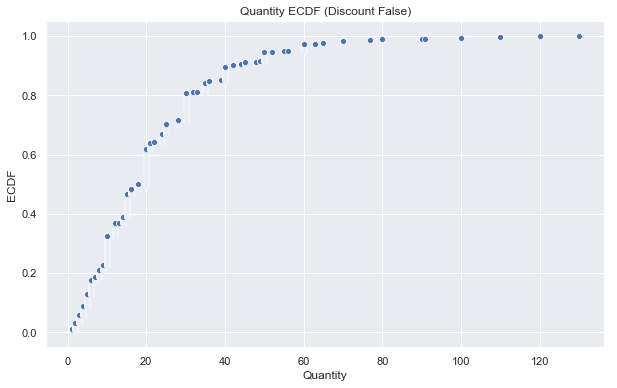

In [21]:
_ = plt.figure(figsize=(10,6))
_ = sns.scatterplot(x=quantity_x, y=quantity_y)
_ = plt.title('Quantity ECDF (Discount False)')
_ = plt.xlabel('Quantity')
_ = plt.ylabel('ECDF')

plt.show()

In [22]:
dis_true_x, dis_true_y = ecdf(discount_true['Quantity'])

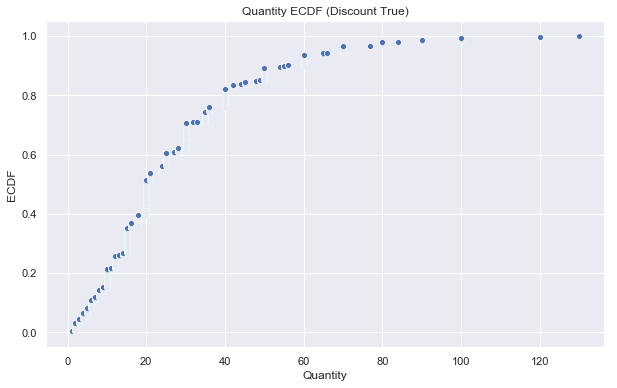

In [23]:
_ = plt.figure(figsize=(10,6))
_ = sns.scatterplot(x=dis_true_x, y=dis_true_y)
_ = plt.title('Quantity ECDF (Discount True)')
_ = plt.xlabel('Quantity')
_ = plt.ylabel('ECDF')

plt.show()

### Box Plots

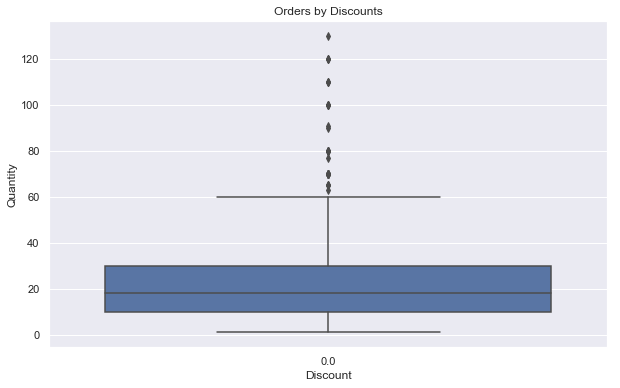

In [24]:
_ = plt.figure(figsize=(10,6))
_ = sns.boxplot(x=discount_false['Discount'], y=discount_false['Quantity'])
_ = plt.title('Orders by Discounts')
plt.show()

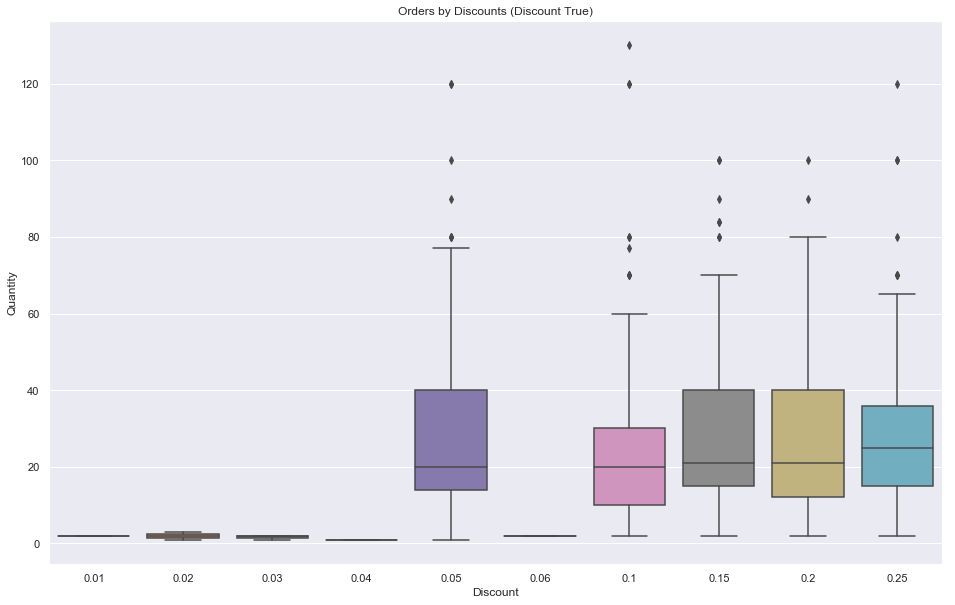

In [25]:
_ = plt.figure(figsize=(16, 10))
_ = sns.boxplot(x=discount_true['Discount'], y=discount_true['Quantity'])
_ = plt.title('Orders by Discounts (Discount True)')
plt.show()

From the EDA we can see that discounts in increments of 5% have more orders.

### Checking for Covariance

In [26]:
discount_categories = pd.get_dummies(orders['Discount'], columns='Discount')
orders_new = pd.concat([orders, discount_categories], axis=1)
orders_new.drop(columns='Discount', inplace=True)

In [27]:
def pearson_r(data1, data2):
    '''
    Computes the pearson correlation between two datasets
    
    returns: covariance
    '''
    return np.cov(data1, data2)[0,1]

In [28]:
discount_corr = pearson_r(discount_false['Discount'], discount_false['Quantity'])
print(f' Pearson Correlation w/ No Discounts: {discount_corr}')

 Pearson Correlation w/ No Discounts: 0.0


In [29]:
no_discount_corr = pearson_r(discount_true['Discount'], discount_true['Quantity'])
print(f' Pearson Correlation w/ No Discounts: {no_discount_corr}')

 Pearson Correlation w/ No Discounts: 0.048496534104356066


### Hacker Statistics

Generate samples of quantities form the OrderDetail table then compare them to the original data.

In [30]:
def replicate(data, func, size=1):
    '''
    Gives a replicate of the data with the given function.
    
    data: a dataset to generate replicates
    func: type of func to pass(np.mean, np.median, np.std)
    size: how many samples to generate
    '''
    sample = np.random.choice(data, len(data))
    return func(sample)

In [31]:
def simulate(data, func, size=1):
    '''
    Generates multiple replicates from the replicate function.
    
    data: a dataset to generate replicates
    func: type of func to pass(mean, median, std)
    size: how many samples to generate    
    '''
    # initialize empty array to store replicates
    replicas = np.empty(shape=size)
    
    # for loop to generate a replica for the given size
    for i in range(size):
        replicas[i] = replicate(data, func)
        
    return replicas

Standard Error of Mean: 0.4096687388075916
Standard deviation: 0.40902291655076184
Mean: 23.81298951276102


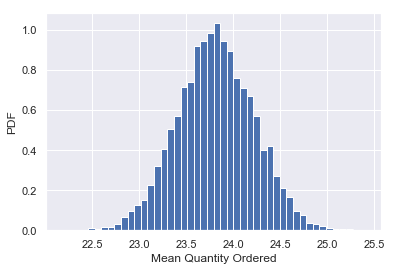

In [32]:
quantity = orders['Quantity']
# take 10000 mean replicas from Quantity
qty_replicas = simulate(quantity, np.mean, 10000)

# computing the standard error of the mean
sem = np.std(quantity) / np.sqrt(len(quantity))
print(f'Standard Error of Mean: {sem}')

std_replicas = np.std(qty_replicas)
print(f'Standard deviation: {std_replicas}')
print(f'Mean: {np.mean(qty_replicas)}')

# Histogram to show results
_ = plt.hist(qty_replicas, bins=int(np.sqrt(len(quantity))), density=True)
_ = plt.xlabel('Mean Quantity Ordered')
_ = plt.ylabel('PDF')

plt.show()

### Confidence Interval

Computing the 95% confidence interval.

In [33]:
np.percentile(qty_replicas, [2.5, 97.5])

array([23.00741299, 24.61345708])

### Linear Regression 

In [34]:
def lin_reg_sample_pairs(x, y, size=1):
    '''
    Perform pair sampling for linear regression
    
    size: number of samples
    '''
    
    # create indices for the same size as x.
    indices = np.arange(len(x))
    
    # empty arrays to store slopes and intercepts
    slopes = np.empty(size)
    intercepts = np.empty(size)
    
    # for loop to generate replicas
    for i in range(size):
        index = np.random.choice(indices, size=len(x))
        sample_x, sample_y = x[indices], y[indices]
        slopes[i], slopes[i] = np.polyfit(sample_x, sample_y, deg=1)
        
    return slopes, intercepts

In [35]:
# generate samples of slopes and intercepts using the above function.
qty_m, qty_b = lin_reg_sample_pairs(orders['Discount'], orders['Quantity'], size=1000)

In [36]:
# the confidence interval for slope and intercept
print(f'Confidence interval for slope: {np.percentile(qty_m, [2.5, 97.5])}')

Confidence interval for slope: [22.16682896 22.16682896]


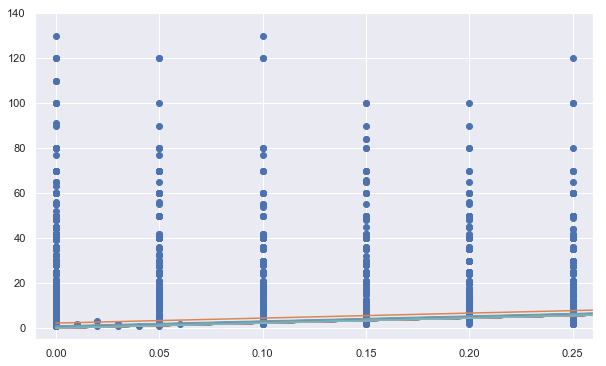

In [37]:
_ = plt.figure(figsize=(10, 6))
# generating regressions
x = np.array([0, 100])

# the regression for the samples
for i in range(100):
    _ = plt.plot(x, qty_m[i] * x + qty_b[i])
    _ = plt.xlim(-0.01, .26)
    _ = plt.ylim((-5, 140))
    
# regression for original data
_ = plt.scatter(orders['Discount'], orders['Quantity'])

In [38]:
def permutation_data(data1, data2):
    '''
    Generate a permuation sample from two datasets.
    
    data1: a 1D array
    data2: a 1D array
    
    returns permuted_data1, permuted_data2
    '''
    
    #concatenate 2 datasets
    data = np.concatenate((data1, data2))
    
    # permute the concatenated array
    permuted_array = np.random.permutation(data)
    
    # split the data into the original sizes
    perm_data1 = permuted_array[:len(data1)]
    perm_data2 = permuted_array[len(data1):]
    
    return perm_data1, perm_data2

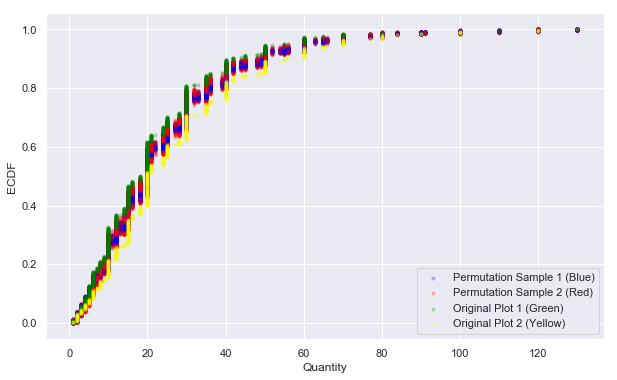

In [39]:
plt.figure(figsize=(10, 6))
for sample in range(50):
    permuted1, permuted2 = permutation_data(discount_false['Quantity'], discount_true['Quantity'])
    
    #computing ECDFs for permuted1 and permuted2
    x1, y1 = ecdf(permuted1)
    x2, y2 = ecdf(permuted2)
    
    #plotting the ECDFs
    perm_plot1 = plt.scatter(x1, y1, c='blue', s=10, alpha=0.2)
    perm_plot2 = plt.scatter(x2, y2, c='red', s=10, alpha=0.2)
    
# plot for the original dataset
ox1, oy1 = ecdf(discount_false['Quantity'])
ox2, oy2 = ecdf(discount_true['Quantity'])

orig_plot1 = plt.scatter(ox1, oy1, c='green', s=10, alpha=0.2)
orig_plot2 = plt.scatter(ox2, oy2, c='yellow', s=10, alpha=0.2)
_ = plt.xlabel('Quantity')
_ = plt.ylabel('ECDF')
_ = plt.legend([perm_plot1, perm_plot2, orig_plot1, orig_plot2] , 
               ['Permutation Sample 1 (Blue)', 'Permutation Sample 2 (Red)', 
                'Original Plot 1 (Green)', 'Original Plot 2 (Yellow)'], loc=4)

plt.show()

The distributions of the datasets [Permutation Sample 1, Permutation Sample 2, Original 1, Original 2] have the same distribution because the points overlap. This is verified by the histogram and ECDFs created earlier in the notebook.

In [40]:
def permutation_replicates(data1, data2, func, size=1):
    '''
    Generate multiple permutation replicates from a sample distribution.
    
    data1: a numpy array
    data2: a numpy array
    func: a numpy function(np.mean, np.std, np.var, etc...)
    size: number of replicates to generate
    
    returns: perm_replicates
    '''
    
    # initialize an empty array with the size parameter
    replicates = np.empty(size)
    
    # for loop to generate replicates to put into replicates array
    for i in range(size):
        sample1, sample2 = permutation_data(data1, data2)
        
        # Compute the test statistic for each iteration and then add
        # to replicates array
        replicates[i] = func(sample1, sample2)
        
    return replicates

In [41]:
def diff_of_mean(data1, data2):
    '''
    Calculate the difference of means between two means.
    
    data1: an array
    data2: an array
    
    returns: diff
    '''
    
    diff = np.mean(data1) - np.mean(data2)
    
    return diff

## Hypothesis Testing

In [42]:
# the pearson correlation between quantity and discount
qty_corr = pearson_r(discount_true['Discount'], discount_true['Quantity'])
print(f'Pearson Coefficient: {qty_corr}')

Pearson Coefficient: 0.048496534104356066


> H0: $\rho_0 \geq \rho_1$
The pearson correlation between discounts and quantities ordered is greater than or equal 4.84%


> H1: $\rho_0 < \rho_1$
The pearson correlation between discounts and quantities ordered is less than 4.84%

In [43]:
# initialize empty permutation array of 10000
permutation_arr = np.empty(10000)

# for loop to create samples of the pearson coefficient
for i in range(10000):
    
    #quantity & discount pearson coefficient samples
    qty_sample = np.random.permutation(orders['Quantity'])
    
    # calculates the pearson coeffificent for each sample 
    # distribution and stores it into qty_sample
    permutation_arr[i] = pearson_r(orders['Discount'], qty_sample)
    
p_value = np.sum(permutation_arr >= qty_corr) / len(permutation_arr)

if p_value <= 0.05:
    print(f'P-value: {p_value}, Reject null hypothesis')
else:
    print(f'P-value: {p_value}, Fail to reject null hypothesis')

P-value: 0.0759, Fail to reject null hypothesis


With a P-value of 0.0758 I fail to reject the null hypothesis and that there is a correlation between discounts and the amount of quantities ordered.

Now we shall explore discounts!

In [44]:
mean_difference = diff_of_mean(discount_false['Quantity'], discount_true['Quantity'])
print(f'Difference of means: {mean_difference}')

# a simulation of the difference in mean between quantities ordered with discounts
# and quantities ordered without discounts
qty_simulation = permutation_replicates(discount_false['Quantity'], discount_true['Quantity'], diff_of_mean, 10000)

#computing the p-value using numpy
p_value = np.sum(qty_simulation >= mean_difference) / len(qty_simulation)

print(f'P-value: {p_value}')

Difference of means: -5.394523243866239
P-value: 1.0


# EXPERIMENT NOT REAL!

In [45]:
c.execute('''
SELECT AVG(ShippedDate) - AVG(OrderDate)
FROM [Order];
''').fetchall()

[(0.012343068193786166,)]

In [46]:
shipped = pd.read_sql_query('''
SELECT OrderDate, ShippedDate
FROM [Order];
''', conn)

In [47]:
shipped.head()

,OrderDate,ShippedDate
0,2012-07-04,2012-07-16
1,2012-07-05,2012-07-10
2,2012-07-08,2012-07-12
3,2012-07-08,2012-07-15
4,2012-07-09,2012-07-11


In [48]:
shipped['OrderDate'] = pd.to_datetime(shipped['OrderDate'])
orderdate = shipped['OrderDate']
shipped['ShippedDate'] = pd.to_datetime(shipped['ShippedDate'])
shippeddate = shipped['ShippedDate']

In [49]:
np.mean(orderdate.dt.date - shippeddate.dt.date

SyntaxError: unexpected EOF while parsing (<ipython-input-49-562d7249d835>, line 1)

In [ ]:
np.mean(orderdate.dt.date - shippeddate.dt.date)
times = []
for i in range(100):
    time = np.random.permutation(np.mean(orderdate.dt.date - shippeddate.dt.date))
    times.append(time)
np.mean(times)

In [ ]:
processing_time = [shipped['OrderDate'][i] - shipped['ShippedDate'][i] for i in range(len(shipped))]

In [ ]:
processing_time[:5]

In [ ]:
## Hypothesis Testing

In [ ]:
import statsmodels.api 